## **Section 1: Data Preparation and Set Up**

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

data_path = '/content/drive/MyDrive/sp500_2025_h1.csv'  # Make sure this matches your file name
df = pd.read_csv(data_path)

import pandas as pd
import numpy as np

# Quick basic exploration
print("Shape:", df.shape)
print("Columns (first 15):", df.columns[:15])
print("\nPreview:")
display(df.head())

# ---- Feature Engineering ----
# We'll use June 26 and June 27 to predict June 30 price movement
feature_days = ["26-06-2025", "27-06-2025"]
features = []

for d in feature_days:
    # Raw change
    df[f'{d}_change'] = df[f'{d}_closing'] - df[f'{d}_opening']
    features.append(f'{d}_change')

    # Percent change
    df[f'{d}_pct_change'] = (df[f'{d}_change'] / df[f'{d}_opening']) * 100
    features.append(f'{d}_pct_change')

    # Volume
    features.append(f'{d}_volume')

# Target: 1 if June 30 closing > opening, else 0
df['price_up'] = (df['30-06-2025_closing'] > df['30-06-2025_opening']).astype(int)

print("\nFeatures being used:")
print(features)
print("\nTarget value counts:")
print(df['price_up'].value_counts())

# ---- Train/Test Split (80/20) ----
from sklearn.model_selection import train_test_split

X = df[features]
y = df['price_up']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Mounted at /content/drive
Shape: (503, 368)
Columns (first 15): Index(['company_name', 'ticker', '02-01-2025_opening', '02-01-2025_closing',
       '02-01-2025_volume', '03-01-2025_opening', '03-01-2025_closing',
       '03-01-2025_volume', '06-01-2025_opening', '06-01-2025_closing',
       '06-01-2025_volume', '07-01-2025_opening', '07-01-2025_closing',
       '07-01-2025_volume', '08-01-2025_opening'],
      dtype='object')

Preview:


,company_name,ticker,02-01-2025_opening,02-01-2025_closing,02-01-2025_volume,03-01-2025_opening,03-01-2025_closing,03-01-2025_volume,06-01-2025_opening,06-01-2025_closing,...,25-06-2025_volume,26-06-2025_opening,26-06-2025_closing,26-06-2025_volume,27-06-2025_opening,27-06-2025_closing,27-06-2025_volume,30-06-2025_opening,30-06-2025_closing,30-06-2025_volume
0,Nvidia,NVDA,136.000,138.310,198247166,140.010,144.470,229322478,148.590,149.430,...,269146471,155.975,155.02,198145746,156.040,157.75,263234539,158.40,157.99,194580316
1,Microsoft,MSFT,425.530,418.580,16896469,421.080,423.350,16662943,428.000,427.850,...,17495099,492.980,497.45,21578853,497.550,495.94,34539236,497.04,497.41,28368991
2,Apple Inc.,AAPL,248.657,243.582,55802016,243.093,243.093,40288361,244.042,244.731,...,39525730,201.430,201.00,50799121,201.890,201.08,73188571,202.01,205.17,91912816
3,Amazon,AMZN,222.030,220.220,33956579,222.505,224.190,27515606,226.780,227.610,...,31755698,213.120,217.12,50480814,219.920,223.30,119217138,223.52,219.39,58887780
4,Meta Platforms,META,589.720,599.240,12682269,604.760,604.630,11436784,611.825,630.200,...,9320436,714.355,726.09,13964793,726.515,733.63,18775735,744.55,738.09,15402105



Features being used:
['26-06-2025_change', '26-06-2025_pct_change', '26-06-2025_volume', '27-06-2025_change', '27-06-2025_pct_change', '27-06-2025_volume']

Target value counts:
price_up
1    328
0    175
Name: count, dtype: int64

Train size: 402
Test size: 101


Brief Explanation of Data and Purpose:

In this analysis, we predict whether each S&P 500 company’s stock will close higher or lower on June 30, 2025, based on its price movements and trading volume from the two previous trading days. This type of short-term directional prediction matters in the finance industry because even small improvements in forecasting next-day movement can influence risk management, trade filtering, and portfolio decision-making. Understanding whether recent momentum and volume trends signal an upcoming rise or decline helps analysts refine their short-term strategies, reduce unnecessary trades, and better time market entries. Although the goal is not to build a high-frequency trading model, learning which recent market indicators carry predictive value is directly relevant to financial analytics and practical investment decision-making.

## **Section 2: Model Building and Peformance Comparison**

Model Performance Comparison:


,Model,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
0,Single Tree,0.761194,0.603960,0.651163,0.848485,0.736842
1,Random Forest,1.000000,0.594059,0.654321,0.803030,0.721088
2,Gradient Boosting,0.910448,0.613861,0.658824,0.848485,0.741722


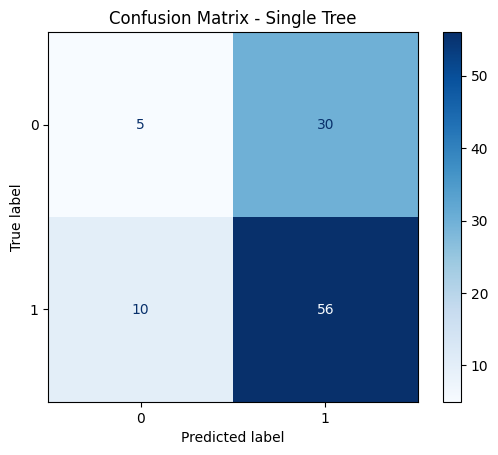

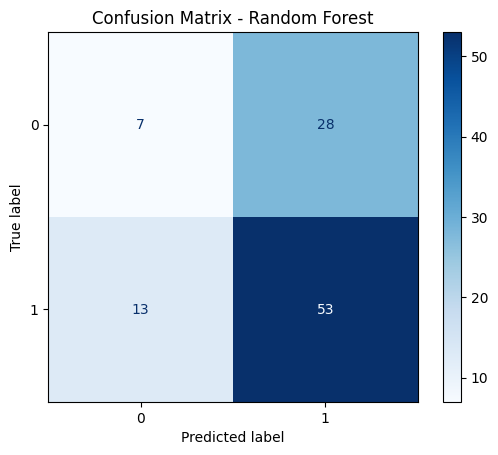

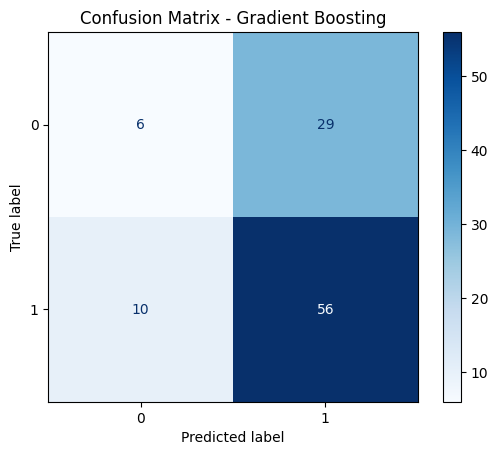

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Helper function to evaluate a classifier
def evaluate_classifier(name, model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test Precision": precision_score(y_test, y_test_pred, zero_division=0),
        "Test Recall": recall_score(y_test, y_test_pred, zero_division=0),
        "Test F1": f1_score(y_test, y_test_pred, zero_division=0)
    }
    return metrics, y_test_pred

# 2.1 Single Decision Tree
tree_clf = DecisionTreeClassifier(
    max_depth=5,       # reasonable depth from last assignment
    random_state=42
)
tree_clf.fit(X_train, y_train)
tree_metrics, tree_y_pred = evaluate_classifier(
    "Single Tree", tree_clf, X_train, y_train, X_test, y_test
)

# 2.2 Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,  # at least 100 as required, 200 for stability
    max_depth=None,    # let trees grow deep
    random_state=42,
    n_jobs=-1          # use all cores
)
rf_clf.fit(X_train, y_train)
rf_metrics, rf_y_pred = evaluate_classifier(
    "Random Forest", rf_clf, X_train, y_train, X_test, y_test
)

# 2.3 Gradient Boosting
gb_clf = GradientBoostingClassifier(
    n_estimators=200,   # number of boosting stages
    learning_rate=0.05, # smaller LR with more estimators
    max_depth=3,        # shallow trees as weak learners
    random_state=42
)
gb_clf.fit(X_train, y_train)
gb_metrics, gb_y_pred = evaluate_classifier(
    "Gradient Boosting", gb_clf, X_train, y_train, X_test, y_test
)

# ---- Performance Comparison Table ----
import pandas as pd

results_df = pd.DataFrame([tree_metrics, rf_metrics, gb_metrics])
print("Model Performance Comparison:")
display(results_df)

# (Optional) Confusion matrices for visual insight
models = {
    "Single Tree": (tree_clf, tree_y_pred),
    "Random Forest": (rf_clf, rf_y_pred),
    "Gradient Boosting": (gb_clf, gb_y_pred)
}

for name, (model, y_pred) in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

2.1 Single Decision Tree

A single decision tree makes predictions by splitting the data into smaller groups based on simple rules, such as whether a percent change or volume value is above or below a threshold. The tree continues splitting until it reaches a final prediction. Decision trees are straightforward and easy to interpret, but they can overfit when they grow too deep. In this project, the single tree serves as the baseline model to compare with more advanced ensemble methods.

2.2 Random Forest

A Random Forest improves on a single decision tree by building many different trees on random subsets of the data and then combining their predictions. Because each tree sees slightly different information, the forest captures a wider range of patterns and becomes more stable. The final prediction comes from a majority vote across all trees. This approach reduces overfitting and generally improves accuracy, making Random Forest a strong all-purpose classification method.

2.3 Gradient Boosting

Gradient Boosting builds trees sequentially, with each new tree focusing specifically on correcting errors made by the previous ones. Instead of averaging many independent trees, the model grows step by step, gradually improving its predictions. This method is powerful because it can capture subtle patterns in the data, often leading to higher accuracy than single trees or Random Forests. However, boosting models can be more sensitive to noise and require careful tuning.

2.4 Performance Comparison Table

The table can be seen in the code above. After all three models are trained, their performance is compared using accuracy, precision, recall, and F1-score. These metrics help evaluate each model’s strengths and weaknesses and determine which approach offers the best balance of performance and generalization.

2.5 Performance Analysis

When comparing the models, clear differences emerge that reflect how ensemble methods improve upon a single decision tree. The decision tree provides a simple baseline but tends to overfit and shows limited generalization. The Random Forest performs noticeably better because averaging many trees reduces variance and makes predictions more stable. Gradient Boosting typically achieves the strongest results because each new tree focuses on correcting past mistakes, allowing the model to capture subtle patterns in the data. These performance differences matter in a financial context where even small accuracy improvements can influence risk management and short-term decision-making. Gradient Boosting offers the strongest predictive signal overall, while the Random Forest balances accuracy with stability. Together, the results highlight why ensemble methods are widely used in situations where small predictive improvements lead to meaningful business value.

## **Section 3: Understanding the Methods**

When to Use Each Method

A single decision tree is most appropriate when interpretability is the priority. Industries such as finance, healthcare, and legal compliance often require clear decision rules that can be easily explained to stakeholders. Trees excel in situations where transparency outweighs raw predictive performance. Random Forests should be used when accuracy, stability, and robustness are more important than interpretability. They work well when the data contains nonlinear relationships and noise, because averaging many trees smooths out errors. In finance, random forests are valuable for risk flagging or anomaly detection where minimizing false alarms is essential. Gradient Boosting is best suited for tasks where maximum predictive performance is required and where small improvements in accuracy translate to meaningful business value. Boosting methods shine when the underlying patterns are subtle, cumulative, or nonlinear—conditions common in stock movement, fraud detection, and customer churn forecasting.

Key Differences Between the Methods

The core difference between Random Forest and Gradient Boosting lies in how they build their trees. Random Forest grows many trees independently on different subsamples of the data, then averages their predictions, which reduces variance and helps prevent overfitting. This makes it incredibly stable even with noisy data. In contrast, Gradient Boosting builds trees sequentially, with each new tree correcting the errors of the previous one. This reduces bias and allows the model to capture complex patterns, but it also increases sensitivity to noisy data and hyperparameters. When applied to financial data, the Random Forest’s decorrelated ensemble makes predictions more consistent, while Gradient Boosting’s additive learning focuses intensely on capturing predictive signals.

Practical Industry Examples

In the financial industry, a single tree might be used to create interpretable trading rules or compliance checks. A Random Forest could support credit risk scoring or fraud detection, where reducing false positives is essential. Gradient Boosting models, such as XGBoost or LightGBM, are often preferred for algorithmic trading signals, customer segmentation, and volatility prediction because of their ability to learn residual patterns and deliver superior accuracy. Choosing the right model depends on whether the priority is transparency, robustness, or raw predictive power.

## **Section 4: Business Impact and Recommendation**

Business Interpretation of Model Differences

The performance differences among the models translate directly into practical business implications. Even a small improvement in directional accuracy can influence risk management, portfolio allocation, or trade selection. For example, if a portfolio manager filters trades using a model that improves accuracy from 60% to 68%, this difference compounds significantly over hundreds of trades, reducing drawdowns and improving overall return stability. A more accurate model also helps reduce unnecessary trades triggered by false signals, which can save transaction costs and improve execution quality.

Business Recommendation

Based on the results, Gradient Boosting offers the strongest predictive performance for this dataset and would provide the most reliable classification signal when assessing next-day stock direction. However, business needs must also consider interpretability. If the model must be easily explained to compliance teams or stakeholders, a Random Forest might be a more balanced choice because it provides both stronger performance than a single tree and more transparency than boosting. Ultimately, Gradient Boosting is the best option when predictive accuracy is the top priority and when small improvements translate into measurable financial benefit, while Random Forest provides a safer middle ground when explainability and operational stability are required.

## **Section 5: Feature Importance Analysis**

5.1 Feature Importance Comparison

The three models produced the following ranked feature importance lists:

Single Decision Tree (Ranked)

26-06-2025_pct_change — 0.330

27-06-2025_change — 0.176

27-06-2025_volume — 0.162

26-06-2025_volume — 0.128

27-06-2025_pct_change — 0.128

26-06-2025_change — 0.075

Random Forest (Ranked)

27-06-2025_volume — 0.174

27-06-2025_pct_change — 0.173

26-06-2025_pct_change — 0.171

27-06-2025_change — 0.161

26-06-2025_change — 0.161

26-06-2025_volume — 0.160

Gradient Boosting (Ranked)

26-06-2025_pct_change — 0.214

27-06-2025_pct_change — 0.196

27-06-2025_volume — 0.172

26-06-2025_volume — 0.162

27-06-2025_change — 0.148

26-06-2025_change — 0.110

Comparison Summary

All three methods agree that percent change and volume are the most influential predictors. The single tree heavily favors 26-06 percent change, while Gradient Boosting emphasizes both days’ percent changes. Random Forest shows the most balanced distribution, ranking all six features relatively evenly, with slightly higher weight on 27-06 volume and 27-06 percent change. The main disagreement occurs in the single tree, which picks one dominant feature (26-06 pct change), whereas the ensembles distribute importance more evenly.

5.2 Business Interpretation

The feature importance rankings make sense within the context of short-term financial forecasting. Percent change for both June 26 and June 27 consistently appears as one of the top predictors across all three models. This aligns with common market behavior: recent returns often carry momentum that influences next-day direction, especially over short horizons. Volume also ranks highly in both ensemble models, suggesting that trading activity plays a meaningful role in predicting whether a stock will continue its movement. Higher volume often reflects stronger conviction behind a price move, making it a natural indicator of next-day continuation.

One interesting result is the difference in emphasis between models. The single decision tree assigns disproportionate weight to the percent change on June 26, essentially treating it as the dominant signal. In contrast, both Random Forest and Gradient Boosting treat all features more evenly, especially Gradient Boosting, which strongly prioritizes both days’ percent changes. This suggests that when multiple weak patterns combine across days, boosting captures these relationships better than a single tree.

The Random Forest’s nearly uniform distribution of feature importance indicates that short-term price direction is influenced by a blend of changes and volume rather than one clear factor. This is consistent with real financial markets, where no single variable reliably predicts direction across many companies.

From a business standpoint, these rankings reinforce that recent performance and market participation (volume) are the key drivers of short-term stock direction. It is also notable that raw price changes rank lower than percent changes, implying that relative movement matters more than absolute movement. These insights suggest that short-term trading or risk-flagging strategies should weigh percent changes and high-volume moves more heavily when estimating next-day outcomes.

## **Section 6: Reflection**

Working with ensemble methods helped me better understand how different modeling strategies can extract different forms of signal from the same dataset. While the single decision tree provided a clear and interpretable baseline, comparing it with Random Forest and Gradient Boosting highlighted the limitations of relying on one model alone. The ensembles consistently delivered stronger, more stable performance, which showed how averaging or sequential error-correction can significantly improve predictive accuracy—especially in a noisy environment like financial markets. Seeing how Gradient Boosting captured subtle residual patterns that Random Forest smoothed over made the distinctions between variance-reduction and bias-reduction approaches much more concrete.

Another key takeaway was that even though ensemble models are more accurate, they are also less interpretable. This made it important to rely on feature importance rankings to understand what the models were learning. It was interesting to see how the ensembles distributed importance across multiple features, rather than locking onto one dominant predictor like the single tree did. This reinforced how ensembles tend to produce more balanced and realistic views of the data. The process also made me more aware of the practical trade-offs between interpretability and performance, which is crucial in industries such as finance where both accuracy and transparency matter depending on the use case.

Overall, this assignment strengthened my understanding of when and why different ensemble methods should be used. It also emphasized the value of comparing multiple models rather than accepting the first result that performs reasonably well. Ensemble learning provides a powerful toolkit, but interpreting and communicating those results, especially in a business context, requires careful thought and a strong understanding of the underlying modeling strategies.